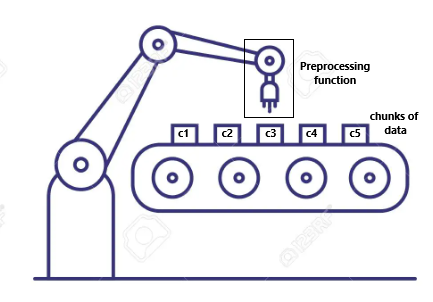

In [1]:
import numpy as np 
import pandas as pd 
import datetime
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import gc
%matplotlib inline

It will have happened more than once among us kagglers to preprocess a large database and pray that our kernel does not reset due to **over-allocation** of memory.

Fortunately, there are tricks, which consist of preprocessing the data in **chunks**, so that the calculations do not stress the RAM.

Obviously, the division of data into chunks does not follow a standard rule, but depends on the case study and the type of calculations we have to perform.

For example, usually when dealing with time series of bank data, it is very important to preprocess by grouping the data by **customer id**.


The simplest strategy is to remove the id of **duplicate** customers, and split the data into chunks of the **same size**. Other times we need to **keep** the duplicates to see if customers have different behaviour over time; for example, it is very common to count (**count()**) how many times a customer occurs in the data.

**READ EXAMPLE DATASET**

For demonstration purposes, we choose a small dataset. There are **100000** rows, and we select 2 columns (**ip** and **channel**)

In [2]:
#wanted columns
columns = ['ip', 'channel']
dtypes = {
        'ip'      : 'uint32',
        'channel' : 'uint16',
        }

ips_df = pd.read_csv('../input/talkingdata-adtracking-fraud-detection/train_sample.csv', usecols=columns, dtype=dtypes)

In [3]:
print(ips_df.info())
print(ips_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   ip       100000 non-null  uint32
 1   channel  100000 non-null  uint16
dtypes: uint16(1), uint32(1)
memory usage: 586.1 KB
None
       ip  channel
0   87540      497
1  105560      259
2  101424      212
3   94584      477
4   68413      178


**CHUNKS OF THE SAME SIZE** (common approach)

In [4]:
# Dividing our dataset into 4 parts we obtain 25000 rows per chunk
num_parts = 4
all_rows = len(ips_df)
chunk = all_rows//num_parts

We want to perform a single calculation, i.e. **count** how many times the variable **channel** occurs for each **ip**. But remember that we can also calculate the sum (sum()), standard deviation (std()), number of unique (nunique()) etc...

In [5]:
for p in range(0,num_parts):
    start = p*chunk
    end = p*chunk + chunk
    if end < all_rows:
        group = ips_df[start:end][['ip', 'channel']].groupby('ip', as_index=False).count()
    else:
        group = ips_df[start:][['ip', 'channel']].groupby('ip', as_index=False).count()
    print(group)

           ip  channel
0           9        1
1          10        1
2          19        1
3          27        1
4          36        1
...       ...      ...
14995  363876        1
14996  363962        1
14997  364084        1
14998  364338        1
14999  364410        1

[15000 rows x 2 columns]
           ip  channel
0          10        1
1          20        2
2          27        1
3          31        1
4          59        1
...       ...      ...
15072  363710        1
15073  363962        1
15074  363995        1
15075  364168        1
15076  364471        1

[15077 rows x 2 columns]
           ip  channel
0          10        1
1          25        1
2          27        2
3          36        1
4          59        1
...       ...      ...
15081  363869        1
15082  363895        1
15083  363995        1
15084  364127        1
15085  364757        1

[15086 rows x 2 columns]
           ip  channel
0          20        2
1          27        1
2          33        1
3 

**LOOK CAREFULLY**, the **ip = 10** occurs in the **first**, **second** and **third** group/chunk. Specifically, the ip = 10 occurs **once** in the first 3 groups, so what we have to do is **merge** the groups and do the sum per row, so that we get 3 (1 + 1 + 1).

This process is annoying and would increase the complexity of the calculation, and consequently the RAM used. To remedy this, we can create variable chunks. 

**CHUNKS OF DIFFERENT SIZE** (improved approach)

In [6]:
#sort the dataset by ip and reset the index 
ips_df.sort_values(by=['ip'], inplace  = True)
ips_df.reset_index(drop = True, inplace = True)
ips_df.head()

,ip,channel
0,9,244
1,10,107
2,10,319
3,10,140
4,19,379


Create a **window** of values so as to be sure not to cut out the most frequent values

EXAMPLE: 

Suppose we have a list, and **imagine** that this list is actually an ID column of customers:

list_ID = [1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 4, 8, 8, 9, 9, 10, 12, 18, 19, 20]


We divide the list into 2 chunks or batches of data, and we get:

chunk1 = [1, 2, 2, 3, 3, 3, 4, 4, 4, 4]
chunk2 = [4, 8, 8, 9, 9, 10, 12, 18, 19]

As you can see, the customer with **ID = 4** is in both chunks, and we want to avoid this. What we need to do is update chunk1, so that the client with **ID = 4** is only in this chunk, and consequently both chunks will have a different size.

What we need to do is to calculate the **unique values** of chunk1. Yes, very fast and simple, but if we have an ID column of 5 million customers and we need to optimise the calculation to avoid excessive RAM usage, how can we do it?

Create a **WINDOW** of rows, so that we only work on the last part of the chunk. Let us see it in practice

WINDOW = 5 (number of times the most frequent value (ID = 4) occurs in list_ID)

This means that we only need to work on the **last 5 rows + 1**

chunk_window = [3, 3, 4, 4, 4, 4]

We now calculate the **unique values**, and following the **second last value**

list_unique = [3, 4]

second_last = [3]

Perfect now we can update **chunk1** with a new size. The last row must correspond to exactly this value.

chunk1 = [1, 2, 2, 3, 3, 3]

chunk2 = [4, 4, 4, 4, 4, 8, 8, 9, 9, 10, 12, 18, 19]


This way we are sure that customers do not end up in separate chunks. Now let us move on to the code 

In [7]:
#calculate the most common value with the "mode", and the "window"
import operator as op
a_list = list(ips_df['ip'])
most_common = int(ips_df['ip'].mode())
window = op.countOf(a_list,most_common)

In [8]:
#function to get the unique values
def unique(list1):
    x = np.array(list1)
    return np.unique(x)

In [9]:
#set start = 0
start = 0
#new dataframe to append the results of the for loop
new_ips_df=pd.DataFrame()
for p in range(0,num_parts):
    end = p*chunk + chunk
    if end < all_rows:
        chunk_window = ips_df[start:end].tail(window+1)
        list_unique = unique(chunk_window['ip'])
        second_last = list_unique[-2]
        new_end = chunk_window[chunk_window['ip'] == second_last].tail(1).index.tolist()[0]
        new_chunk = ips_df[start:new_end+1][['ip', 'channel']].groupby('ip', as_index=False).count()
    else:
        new_chunk = ips_df[start:][['ip', 'channel']].groupby('ip', as_index=False).count()
    start = new_end+1
    new_ips_df = new_ips_df.append(new_chunk, ignore_index=True)

In [10]:
new_ips_df

,ip,channel
0,9,1
1,10,3
2,19,1
3,20,4
4,25,1
...,...,...
34852,364515,1
34853,364621,1
34854,364630,1
34855,364648,1


Well done, now try it yourself with the **7.54GB** dataset (train.csv)

In [11]:
#wanted columns
columns = ['ip', 'channel']
dtypes = {
        'ip'      : 'uint32',
        'channel' : 'uint16',
        }

ips_df = pd.read_csv('../input/talkingdata-adtracking-fraud-detection/train.csv', usecols=columns, dtype=dtypes)

In [12]:
print(ips_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184903890 entries, 0 to 184903889
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   ip       uint32
 1   channel  uint16
dtypes: uint16(1), uint32(1)
memory usage: 1.0 GB
None


In [13]:
# Dividing our dataset into 4 parts we obtain 46225972 rows per chunk
num_parts = 4
all_rows = len(ips_df)
chunk = all_rows//num_parts
#sort the dataset by ip and reset the index 
ips_df.sort_values(by=['ip'], inplace  = True)
ips_df.reset_index(drop = True, inplace = True)
ips_df.head()

,ip,channel
0,1,449
1,1,477
2,1,477
3,1,178
4,1,134


In [17]:
#calculate the most common value with the "mode", and the "window"
import operator as op
a_list = list(ips_df['ip'])
most_common = int(ips_df['ip'].mode())
window = op.countOf(a_list,most_common)

del a_list

gc.collect()

1042

In [18]:
#function to get the unique values
def unique(list1):
    x = np.array(list1)
    return np.unique(x)

In [19]:
#set start = 0
start = 0
#new dataframe to append the results of the for loop
new_ips_df=pd.DataFrame()
for p in range(0,num_parts):
    end = p*chunk + chunk
    if end < all_rows:
        chunk_window = ips_df[start:end].tail(window+1)
        list_unique = unique(chunk_window['ip'])
        second_last = list_unique[-2]
        new_end = chunk_window[chunk_window['ip'] == second_last].tail(1).index.tolist()[0]
        new_chunk = ips_df[start:new_end+1][['ip', 'channel']].groupby('ip', as_index=False).count()
    else:
        new_chunk = ips_df[start:][['ip', 'channel']].groupby('ip', as_index=False).count()
    start = new_end+1
    new_ips_df = new_ips_df.append(new_chunk, ignore_index=True)
    del new_chunk

In [20]:
new_ips_df

,ip,channel
0,1,47
1,5,24
2,6,1454
3,9,4029
4,10,1180
...,...,...
277390,364773,15
277391,364774,3
277392,364775,24
277393,364776,309
